In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,auc
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
# There are 12 input variables available in input file.
# The list is  pT0, pT1, pT2, NBjet, Met, MaxDPhi_LMet, MaxDphi_LL, MinDphi_LL, LLPairPt, Mt0, Mt1, Mt2
# We start by reading in a subset of those
col_names=['Pt0','Pt1','Pt2','NBJet','Met','MaxDphi_LMet','MaxDphi_LL','MinDphi_LL','LLPairPt','Mt0','Mt1','Mt2']
cols = list(range(0,12))

In [3]:
ifdir='/home/arnab/Arnab/Work/MyTeaching/MLPhyCourse/week4/Assignment_1/'

In [4]:
#Declare some dataframes and read in the input files
# Here WZBk and ZZBk are pandas dataframes
WZBk = pd.read_csv(f'{ifdir}input_WZ.txt',sep=' ',index_col=None, usecols=cols,names=col_names)
WZBk['label']=0

ZZBk = pd.read_csv(f'{ifdir}input_ZZ.txt',sep=' ',index_col=None, usecols=cols,names=col_names)
ZZBk['label']=1


#Sample a subset of events
#UMAP is computing intensive

WZBk=WZBk.sample(10000)
ZZBk=ZZBk.sample(10000)


# Create one giant dataframe from both together
data = pd.concat([WZBk,ZZBk])

# Split the label column as y, and the input variables as X
X, y = data.values[:,:-1], data.values[:,-1]
print(f'Shapes of data, X, y are {data.shape}, {X.shape} , {y.shape}')

Shapes of data, X, y are (20000, 13), (20000, 12) , (20000,)


In [5]:
WZBk.sample(5)

,Pt0,Pt1,Pt2,NBJet,Met,MaxDphi_LMet,MaxDphi_LL,MinDphi_LL,LLPairPt,Mt0,Mt1,Mt2,label
97249,59.163776,57.336586,38.173290,0.0,25.025351,2.753983,2.938386,0.057750,24.362429,28.779659,63.282654,95.588158,0
89321,51.447937,49.586395,16.361824,0.0,209.573547,3.139892,2.873836,0.370635,66.961525,95.429359,146.628128,77.201614,0
46167,84.088806,50.484035,24.939354,0.0,129.136978,1.923835,3.078721,1.346083,59.219463,61.351490,35.231636,84.154488,0
72460,75.142174,52.896122,27.367760,0.0,133.908768,2.447161,1.889435,0.269742,89.754089,216.865997,233.155167,190.748642,0
1284,390.313873,201.026001,93.320038,0.0,138.113876,2.000319,3.130049,0.200953,482.115997,237.034042,302.228271,133.975021,0


In [6]:
#splitting

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.5)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
n_features = X_train.shape[1]
print(f'The number of input variables is {n_features}')

(10000, 12) (10000, 12) (10000,) (10000,)
The number of input variables is 12


In [7]:
#scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler=MinMaxScaler((0,1))
scaler.fit(X_train)

## Transform train and test data
X_train = scaler.transform(X_train)
X_test=scaler.transform(X_test)


In [8]:

def plot_performance(train_X,train_y,test_X,test_y,model):
    #Setup some new dataframes  t_df is testing, v_df is training (or validation)
    t_df = pd.DataFrame()
    v_df = pd.DataFrame()
    t_df['train_truth'] = train_y
    t_df['train_prob'] = 0
    v_df['test_truth'] = test_y
    v_df['test_prob'] = 0

    # Now we evaluate the model on the test and train data by calling the
    # predict function

    val_pred_proba = model.predict(test_X)
    train_pred_proba = model.predict(train_X)
    t_df['train_prob'] = train_pred_proba
    v_df['test_prob'] = val_pred_proba

    # Okay so now we have the two dataframes ready.
    # t_df has two columns for training data  (train_truth and train_prob)
    # v_df has two columns for testing data  (train_truth and train_prob)

    # Now we get the ROC curve, first for testing
    fpr, tpr, _ = roc_curve(test_y,val_pred_proba)
    auc_score = auc(fpr,tpr)
    # Now the ROC curve for training data
    fpr1, tpr1, _ = roc_curve(train_y,train_pred_proba)
    auc_score1 = auc(fpr1,tpr1)


    # Now we plot the NN output
    mybins = np.arange(0,1.05,0.05)

    # First we make histograms to plot the testing data as points with errors
    testsig = plt.hist(v_df[v_df['test_truth']==1]['test_prob'],bins=mybins)
    testsige = np.sqrt(testsig[0])
    testbkg = plt.hist(v_df[v_df['test_truth']==0]['test_prob'],bins=mybins)
    testbkge = np.sqrt(testbkg[0])


    plt.figure(figsize=(8,8))
    plt.errorbar(testsig[1][1:]-0.025, testsig[0], yerr=testsige, fmt='.', color="xkcd:green",label="Test ZZ", markersize='10')
    plt.errorbar(testbkg[1][1:]-0.025, testbkg[0], yerr=testbkge, fmt='.', color="xkcd:denim",label="Test WZ", markersize='10')
    plt.hist(t_df[t_df['train_truth']==1]['train_prob'],bins=mybins, histtype='step', label="Train ZZ", linewidth=3, color='xkcd:greenish',density=False,log=False)
    plt.hist(t_df[t_df['train_truth']==0]['train_prob'],bins=mybins, histtype='step', label="Train WZ", linewidth=3, color='xkcd:sky blue',density=False,log=False)
    plt.legend(loc='upper center')
    plt.xlabel('Score',fontsize=20)
    plt.ylabel('Events',fontsize=20)
    plt.title(f'NN Output',fontsize=20)
    plt.xticks([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

    plt.figure(figsize=(8,8))
    plt.plot(fpr,tpr,color='xkcd:denim blue', label='Testing ROC (AUC = %0.4f)' % auc_score)
    plt.plot(fpr1,tpr1,color='xkcd:sky blue', label='Training ROC (AUC = %0.4f)' % auc_score1)
    plt.legend(loc='lower right',fontsize=20)
    plt.title(f'ROC Curve',fontsize=20)
    plt.xlabel('False Positive Rate',fontsize=20)
    plt.ylabel('True Positive Rate',fontsize=20)
    plt.xlim(0.,1.)
    plt.ylim(0.,1.)
    plt.grid('-',alpha=0.3,lw=2)
    plt.show()


def model_training(train_X,train_y,test_X,test_y,modelname='mymodel.h5'):
    
    n_features=train_X.shape[1]
    
    model = Sequential()
    model.add(Dense(128, activation='relu', kernel_initializer='he_normal', input_dim=n_features))
    model.add(Dense(64, activation='relu', kernel_initializer='he_normal'))
    model.add(Dense(32, activation='relu', kernel_initializer='he_normal'))
    model.add(Dense(1, activation='sigmoid'))
    
    #compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Now we train the model
    history = model.fit(train_X,train_y,epochs=30,batch_size=128,validation_data=(test_X,test_y),verbose=0)
    
    #ModelSummary
    print('The NN architecture is')
    model.summary()
    model.save(modelname)
    
    
    #plot performance
    plot_performance(train_X,train_y,test_X,test_y,model)

# NN Training with 12 variables

The NN architecture is
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1664      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 12,033
Trainable params: 12,033
Non-trainable params: 0
_________________________________________________________________


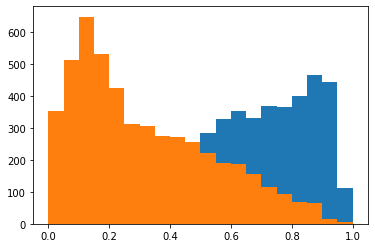

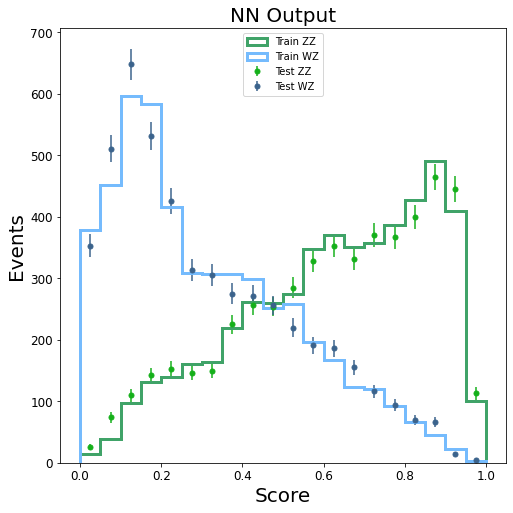

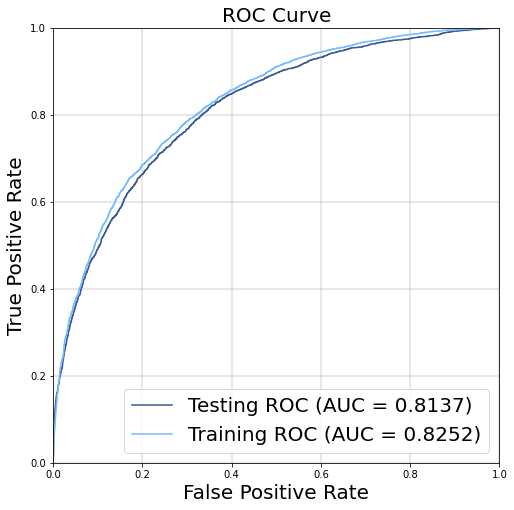

In [9]:
model_training(X_train,y_train,X_test,y_test)

# PCA Algorithm

- Here we will try to use PCA to reduce the dimensionality from 12 to 2
- Then we will use those 2 components in Neural Network
- Then we will compare the ROC with the NN training with 12 variables

In [10]:
from sklearn.decomposition import PCA

####PCA
model_pca=PCA(n_components=2)
model_pca.fit(X_train)
x_pca = model_pca.transform(X_train)


In [11]:
df_pca=pd.DataFrame()
df_pca["y"] = y_train
df_pca["comp1_pca"] = x_pca[:,0]
df_pca["comp2_pca"] = x_pca[:,1]

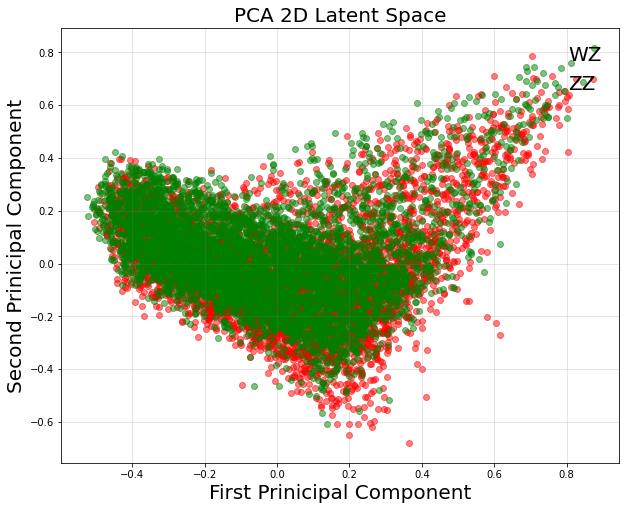

In [12]:
fig,ax = plt.subplots(figsize=(10,8))
ax.scatter(df_pca[df_pca['y']==0]['comp1_pca'],df_pca[df_pca['y']==0]['comp2_pca'],c='red',alpha=0.5,label='WZ')
ax.scatter(df_pca[df_pca['y']==1]['comp1_pca'],df_pca[df_pca['y']==1]['comp2_pca'],c='green',alpha=0.5,label='ZZ')
ax.grid("--",color='gray',alpha=0.2,lw=1)
ax.legend(loc='upper right',fontsize=20,frameon=False)
ax.set_xlabel('First Prinicipal Component',fontsize=20)
ax.set_ylabel('Second Prinicipal Component',fontsize=20)
ax.set_title('PCA 2D Latent Space',fontsize=20)
fig.show()

# NN Training with 2 PCA Variables

In [13]:


X_train_pca = x_pca
X_test_pca  = model_pca.transform(X_test) ## Transforming X_test by the model_pca


The NN architecture is
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               384       
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 10,753
Trainable params: 10,753
Non-trainable params: 0
_________________________________________________________________


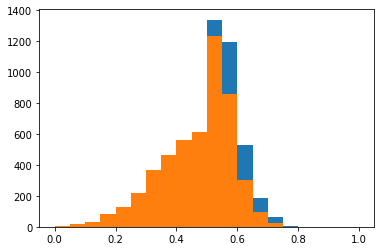

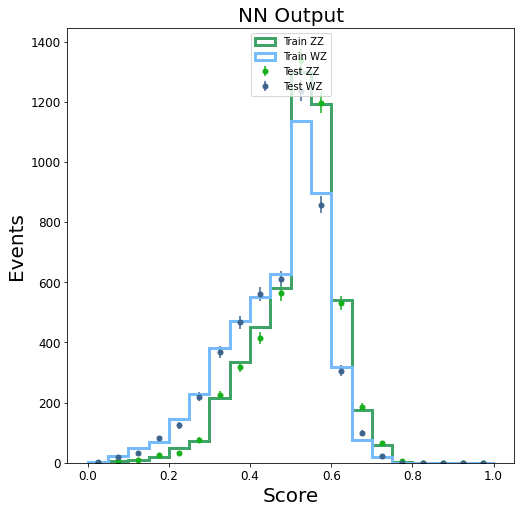

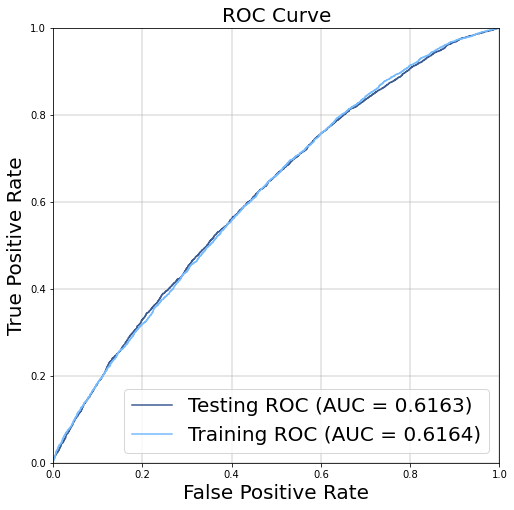

In [14]:
model_training(X_train_pca,y_train,X_test_pca,y_test)

# UMAP model

In [21]:
import umap

In [22]:
#model umap
model_umap=umap.UMAP(n_neighbors=20, min_dist=0.4, n_components=2,metric='euclidean')
model_umap.fit(X_train)
x_umap = model_umap.transform(X_train)


In [23]:
df_umap=pd.DataFrame()
df_umap["y"] = y_train
df_umap["comp1"] = x_umap[:,0]
df_umap["comp2"] = x_umap[:,1]

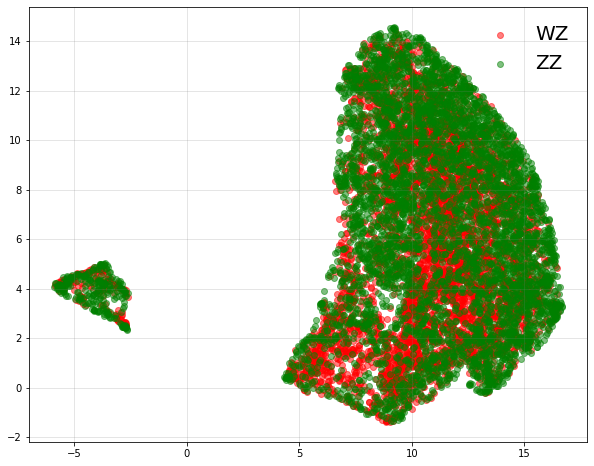

In [24]:
fig,ax = plt.subplots(figsize=(10,8))
ax.scatter(df_umap[df_umap['y']==0]['comp1'],df_umap[df_umap['y']==0]['comp2'],c='red',alpha=0.5,label='WZ')
ax.scatter(df_umap[df_umap['y']==1]['comp1'],df_umap[df_umap['y']==1]['comp2'],c='green',alpha=0.5,label='ZZ')
ax.grid("--",color='gray',alpha=0.2,lw=1)
ax.legend(loc='upper right',fontsize=20,frameon=False)


# NN Training with 2 UMAP variables 

In [25]:
X_train_umap = x_umap
X_test_umap  = model_umap.transform(X_test)

The NN architecture is
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 128)               384       
_________________________________________________________________
dense_13 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_14 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 33        
Total params: 10,753
Trainable params: 10,753
Non-trainable params: 0
_________________________________________________________________


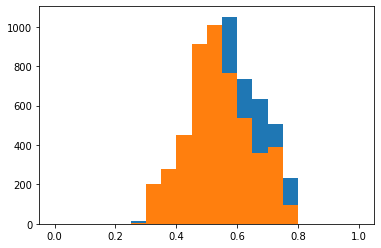

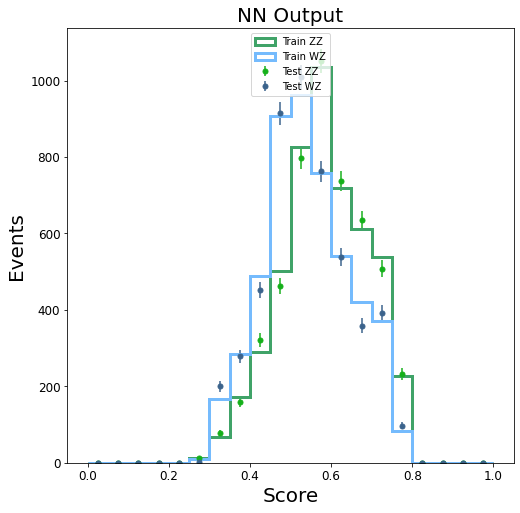

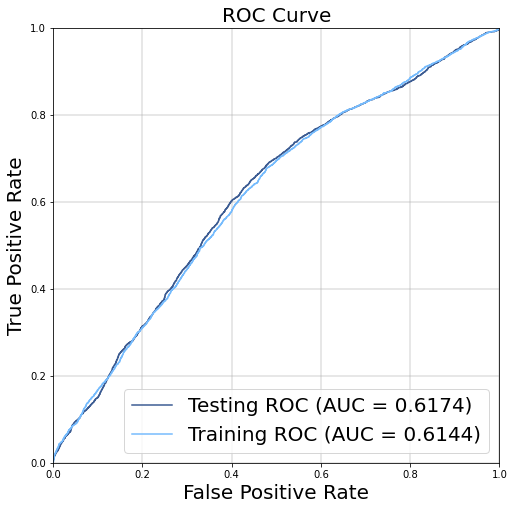

In [26]:
model_training(X_train_umap,y_train,X_test_umap,y_test)